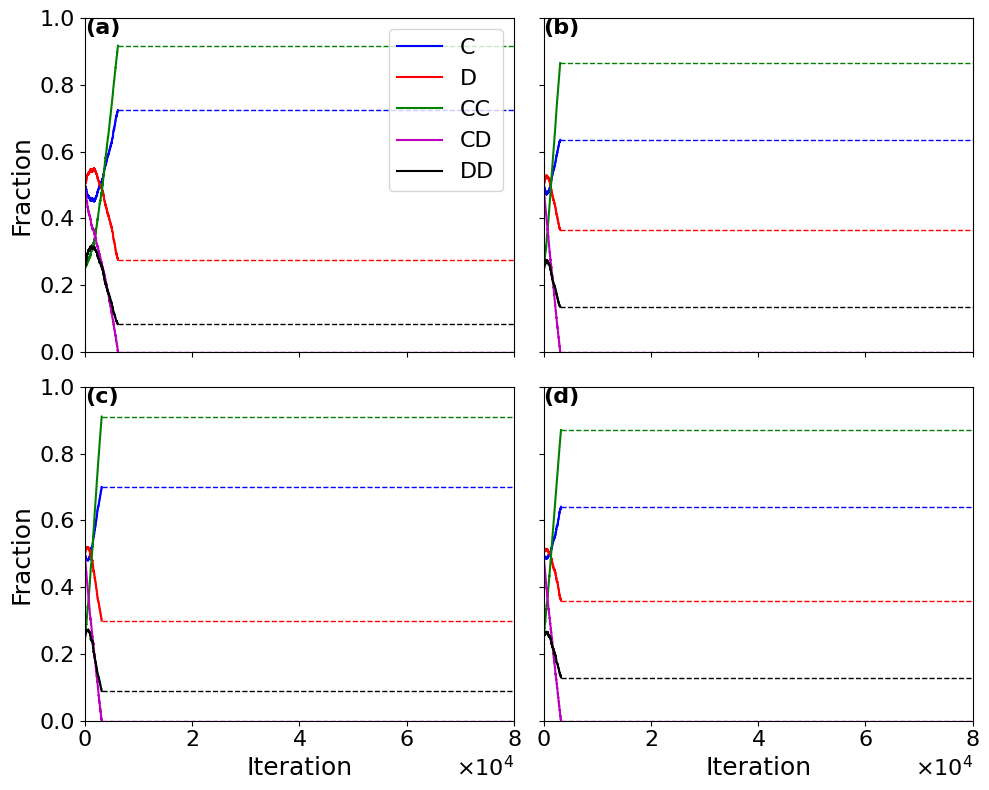

Done.


In [ ]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set matplotlib parameters for consistent plot styling
mpl.rcParams.update({
    'axes.labelsize': 18,   # Font size for X and Y axis labels
    'axes.titlesize': 18,   # Font size for subplot titles
    'xtick.labelsize': 16,  # Font size for X-axis tick labels
    'ytick.labelsize': 16,  # Font size for Y-axis tick labels
    'legend.fontsize': 16,  # Font size for legend
})

# -------------------------------------
# 1. Initialize Network
# -------------------------------------
def initialize_network(N, M, initial_defector_ratio):
    # Set random seed for reproducibility
    random.seed(1337)
    # Create a random graph with N nodes and M edges
    G = nx.gnm_random_graph(N, M)
    # Calculate number of defectors based on initial ratio
    num_defectors = int(N * initial_defector_ratio)
    # Create a list of states: 'D' for defectors, 'C' for cooperators
    states = ['D'] * num_defectors + ['C'] * (N - num_defectors)
    # Shuffle the states randomly
    random.shuffle(states)
    # Assign states to each node in the graph
    for node, state in zip(G.nodes(), states):
        G.nodes[node]['state'] = state
    return G

# -------------------------------------
# 2. Update Strategy & Rewire
# -------------------------------------
def update_strategy(G, alpha, u, discordant_edges):
    # Check if there are any discordant edges to update
    if discordant_edges:
        # Randomly select a discordant edge
        edge = random.choice(tuple(discordant_edges))
        # Identify cooperator (C) and defector (D) nodes
        c_node, d_node = edge if G.nodes[edge[0]]['state'] == 'C' else (edge[1], edge[0])

        # Calculate payoff for cooperator: count of cooperating neighbors
        payoff1 = sum(1 for nbr in G.neighbors(c_node) if G.nodes[nbr]['state'] == 'C')
        # Calculate payoff for defector: (1+u) for C neighbors, u for D neighbors
        payoff2 = sum((1 + u) if G.nodes[n]['state'] == 'C' else u for n in G.neighbors(d_node))

        # Compute payoff difference
        diff = payoff1 - payoff2
        # Calculate probability of strategy change based on payoff difference
        if diff <= 2:
            probability_1_to_2 = 1 / (1 + np.exp(alpha * diff))
        else:
            probability_1_to_2 = 0

        # Decide whether to change strategy based on probability
        if random.random() < probability_1_to_2:
            G.nodes[c_node]['state'] = 'D'  # Cooperator becomes defector
            changed_node = c_node
        else:
            G.nodes[d_node]['state'] = 'C'  # Defector becomes cooperator
            changed_node = d_node

        # Remove the processed edge from discordant edges
        discordant_edges.discard(edge)
        # Update discordant edges based on the changed node's new state
        for nbr in G.neighbors(changed_node):
            e2 = tuple(sorted([changed_node, nbr]))
            if G.nodes[changed_node]['state'] != G.nodes[nbr]['state']:
                discordant_edges.add(e2)  # Add if states differ
            else:
                discordant_edges.discard(e2)  # Remove if states match
    return discordant_edges

def rewire(G, discordant_edges, strategy_type, p, threshold):
    # Check if there are discordant edges to rewire
    if discordant_edges:
        # Randomly select a discordant edge
        edge = random.choice(tuple(discordant_edges))
        # Identify cooperator (C) and defector (D) nodes
        c_node, d_node = edge if G.nodes[edge[0]]['state'] == 'C' else (edge[1], edge[0])
        # Remove the selected edge from the graph
        G.remove_edge(*edge)
        discordant_edges.discard(edge)

        # Identify potential nodes for rewiring (excluding current neighbors and self)
        neighbors_set = set(G.neighbors(c_node))
        potential_nodes = list(set(G.nodes()) - neighbors_set - {c_node})
        new_node = None

        # Handle hybrid strategy: switch based on cooperation fraction
        if strategy_type == 'hybrid':
            coop_fraction = calculate_cooperation_fraction(G)
            strategy_type = 'max_degree_C' if coop_fraction < threshold else 'min_degree_C'

        # Rewiring strategies
        if strategy_type == 'max_degree_C':
            max_deg = -1
            # Find cooperator with maximum degree
            for node in potential_nodes:
                if G.nodes[node]['state'] == 'C' and G.degree[node] > max_deg:
                    max_deg = G.degree[node]
                    new_node = node
        elif strategy_type == 'min_degree_C':
            min_deg = float('inf')
            # Find cooperator with minimum degree
            for node in potential_nodes:
                if G.nodes[node]['state'] == 'C' and G.degree[node] < min_deg:
                    min_deg = G.degree[node]
                    new_node = node
        elif strategy_type == 'probabilistic':
            # Probabilistic rewiring: connect to cooperator with probability p
            if random.random() < p:
                coop_nodes = [n for n in potential_nodes if G.nodes[n]['state'] == 'C']
                if coop_nodes:
                    new_node = random.choice(coop_nodes)
                elif potential_nodes:
                    new_node = random.choice(potential_nodes)
            else:
                if potential_nodes:
                    new_node = random.choice(potential_nodes)
        elif strategy_type == 'random':
            # Random rewiring: connect to any node
            if potential_nodes:
                new_node = random.choice(potential_nodes)

        # Fallback: if no specific node selected, choose randomly
        if new_node is None and potential_nodes:
            new_node = random.choice(potential_nodes)

        # Add new edge and update discordant edges
        if new_node:
            G.add_edge(c_node, new_node)
            for nbr in G.neighbors(c_node):
                e2 = tuple(sorted([c_node, nbr]))
                if G.nodes[c_node]['state'] != G.nodes[nbr]['state']:
                    discordant_edges.add(e2)
                else:
                    discordant_edges.discard(e2)
    return discordant_edges

def calculate_cooperation_fraction(G):
    # Calculate the fraction of cooperators in the network
    c = sum(1 for n in G.nodes() if G.nodes[n]['state'] == 'C')
    return c / G.number_of_nodes() if G.number_of_nodes() > 0 else 0

# -------------------------------------
# 3. Helper Function: Calculate CC, CD, DD Edge Ratios
# -------------------------------------
def get_edge_ratios(G):
    # Initialize counters for edge types
    cc = cd = dd = 0
    # Count CC, CD, and DD edges
    for i, j in G.edges():
        s1 = G.nodes[i]['state']
        s2 = G.nodes[j]['state']
        if s1 == 'C' and s2 == 'C':
            cc += 1
        elif s1 == 'D' and s2 == 'D':
            dd += 1
        else:
            cd += 1
    total = cc + cd + dd
    # Return ratios of each edge type
    if total > 0:
        return cc/total, cd/total, dd/total
    else:
        return 0, 0, 0

# -------------------------------------
# 4. Simulation with Tracking: Cooperators, Defectors, CC, CD, DD Ratios
# -------------------------------------
def simulate_with_tracking_coop_def_edges(
    G, alpha, u, w, max_times, strategy_type, p, threshold, record_interval=1
):
    iteration = 0
    # Initialize set of discordant edges (edges between C and D)
    disc_edges = set(tuple(sorted((i,j))) for i,j in G.edges()
                     if G.nodes[i]['state'] != G.nodes[j]['state'])

    # Lists to track simulation data
    iteration_list = [0]
    coop_fraction_list = []
    def_fraction_list = []
    cc_list = []
    cd_list = []
    dd_list = []

    # Record initial state
    c_frac = calculate_cooperation_fraction(G)
    d_frac = 1 - c_frac
    ccr, cdr, ddr = get_edge_ratios(G)

    coop_fraction_list.append(c_frac)
    def_fraction_list.append(d_frac)
    cc_list.append(ccr)
    cd_list.append(cdr)
    dd_list.append(ddr)

    # Main simulation loop
    while iteration < max_times and disc_edges:
        # With probability w, update strategy; otherwise, rewire
        if random.random() < w:
            disc_edges = update_strategy(G, alpha, u, disc_edges)
        else:
            disc_edges = rewire(G, disc_edges, strategy_type, p, threshold)

        iteration += 1

        # Record data at specified intervals
        if iteration % record_interval == 0:
            iteration_list.append(iteration)
            c_frac = calculate_cooperation_fraction(G)
            d_frac = 1 - c_frac
            ccr, cdr, ddr = get_edge_ratios(G)

            coop_fraction_list.append(c_frac)
            def_fraction_list.append(d_frac)
            cc_list.append(ccr)
            cd_list.append(cdr)
            dd_list.append(ddr)

    # Record final state if not already recorded
    if iteration_list[-1] != iteration:
        iteration_list.append(iteration)
        c_frac = calculate_cooperation_fraction(G)
        d_frac = 1 - c_frac
        ccr, cdr, ddr = get_edge_ratios(G)

        coop_fraction_list.append(c_frac)
        def_fraction_list.append(d_frac)
        cc_list.append(ccr)
        cd_list.append(cdr)
        dd_list.append(ddr)

    return (G, iteration_list,
            coop_fraction_list, def_fraction_list,
            cc_list, cd_list, dd_list)

# -------------------------------------
# 5. Run Four Strategies (Titles: [Random, Cooperator, Minimum Degree, Maximum Degree])
# -------------------------------------
def run_simulation_for_four_strategies(N, M, initial_defector_ratio, alpha, u, w, max_times, p, threshold, record_interval=1):
    """
    Map display titles to internal strategy keys:
        'Random'         -> 'random'
        'Cooperator'     -> 'probabilistic'
        'Minimum Degree' -> 'min_degree_C'
        'Maximum Degree' -> 'max_degree_C'
    """
    title_to_key = {
        'Random': 'random',
        'Cooperator': 'probabilistic',
        'Minimum Degree': 'min_degree_C',
        'Maximum Degree': 'max_degree_C'
    }
    sim_data = {}
    # Run simulation for each strategy
    for strategy_title, internal_key in title_to_key.items():
        G_temp = initialize_network(N, M, initial_defector_ratio)
        results = simulate_with_tracking_coop_def_edges(
            G_temp, alpha, u, w, max_times, internal_key, p, threshold, record_interval
        )
        # Store results (excluding the graph) for each strategy
        sim_data[strategy_title] = results[1:]  # (iters, coop, def, cc, cd, dd)

    return sim_data

def plot_coop_def_edge_ratios_2x2(sim_data_dict):
    """
    Plot in a 2x2 subplot layout:
      - X-axis: iteration (using scientific notation, e.g., 10^4)
      - Lines: Cooperators (blue), Defectors (red), CC (green), CD (magenta), DD (black)
    If simulation ends early, extend with horizontal dashed lines to 10,000 iterations.
    Rules:
      - 'Cooperator' & 'Maximum Degree' => No Y label
      - 'Random' & 'Cooperator'        => No X label
    """
    strategies_in_order = [
        'Random',       # (a)
        'Cooperator',   # (b)
        'Minimum Degree',  # (c)
        'Maximum Degree'   # (d)
    ]
    subplot_labels = ['(a)', '(b)', '(c)', '(d)']

    # Determine global maximum iteration across all strategies
    global_max_iter = 0
    for strat in strategies_in_order:
        if strat in sim_data_dict:
            iters = sim_data_dict[strat][0]  # iteration_list
            if iters[-1] > global_max_iter:
                global_max_iter = iters[-1]
    # Set target iteration to at least 80,000
    target_iter = max(global_max_iter, 80000)

    # Create 2x2 subplot grid
    fig, axs = plt.subplots(2, 2, figsize=(10,8), sharex=True, sharey=True)
    axs = axs.flatten()

    # Configure scientific notation for X-axis
    from matplotlib.ticker import ScalarFormatter
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((0, 0))  # Force scientific notation

    # Plot each strategy
    for i, strat in enumerate(strategies_in_order):
        ax = axs[i]
        # Skip if strategy data is missing
        if strat not in sim_data_dict:
            ax.axis('off')
            continue

        # Add subplot label (e.g., (a)) at top-left
        ax.text(0, 1, subplot_labels[i], transform=ax.transAxes,
                fontsize=16, fontweight='bold', va='top')

        # Extract simulation data
        iters, coop_list, def_list, cc_list, cd_list, dd_list = sim_data_dict[strat]

        # Plot five lines: C (blue), D (red), CC (green), CD (magenta), DD (black)
        ax.plot(iters, coop_list, 'b', label='C')
        ax.plot(iters, def_list, 'r-', label='D')
        ax.plot(iters, cc_list, 'g-', label='CC')
        ax.plot(iters, cd_list, 'm-', label='CD')
        ax.plot(iters, dd_list, 'k-', label='DD')

        # Extend with dashed lines if simulation ends before target_iter
        last_iter = iters[-1]
        if last_iter < target_iter:
            ax.plot([last_iter, target_iter], [coop_list[-1]]*2, 'b--', linewidth=1)
            ax.plot([last_iter, target_iter], [def_list[-1]]*2, 'r--', linewidth=1)
            ax.plot([last_iter, target_iter], [cc_list[-1]]*2, 'g--', linewidth=1)
            ax.plot([last_iter, target_iter], [cd_list[-1]]*2, 'm--', linewidth=1)
            ax.plot([last_iter, target_iter], [dd_list[-1]]*2, 'k--', linewidth=1)

        # Show legend only for 'Random' subplot
        if strat == 'Random':
            ax.legend(loc='best')

        # Apply label rules
        if strat in ['Cooperator', 'Maximum Degree']:
            ax.set_ylabel("")  # No Y label
        else:
            ax.set_ylabel("Fraction")

        if strat in ['Random', 'Cooperator']:
            ax.set_xlabel("")  # No X label
        else:
            ax.set_xlabel("Iteration")

        ax.set_xlim(0, target_iter)
        ax.set_ylim(0, 1)
        # Apply scientific notation to X-axis
        ax.xaxis.set_major_formatter(formatter)

    plt.tight_layout()
    plt.show()

# -------------------------------------
# 7. Main Program
# -------------------------------------
if __name__=="__main__":
    # Parameter settings for the simulation
    N = 1000                  # Number of nodes
    M = 5000                  # Number of edges
    initial_defector_ratio = 0.5  # Initial fraction of defectors
    alpha = 30                 # Strategy update sensitivity parameter
    u = 0.2                    # Payoff parameter for defectors
    w = 0.1                    # Probability of strategy update vs. rewiring
    p = 1                      # Probability for probabilistic rewiring
    threshold = 0.25           # Threshold for hybrid strategy
    max_times = 2*10**6        # Maximum number of iterations
    record_interval = 1        # Interval for recording data

    # Run simulations for four strategies: Random, Cooperator, Minimum Degree, Maximum Degree
    simulation_data = run_simulation_for_four_strategies(
        N, M, initial_defector_ratio, alpha, u, w, max_times, p, threshold, record_interval
    )

    # Plot results in a 2x2 grid:
    # (a) Random, (b) Cooperator, (c) Minimum Degree, (d) Maximum Degree
    # - 'Cooperator' & 'Maximum Degree' omit Y labels
    # - 'Random' & 'Cooperator' omit X labels
    # - Extend dashed lines to 80,000 iterations if simulation ends early
    plot_coop_def_edge_ratios_2x2(simulation_data)

    # Print completion message
    print("Done.")